In [1]:
%load_ext autoreload
%autoreload 2

import os 
# Set the environment for R
# os.environ['R_HOME']= r'C:\Users\tomha\miniconda3\envs\octagon_analysis\lib\R'  # Laptop
# os.environ['R_HOME']=r'D:\Users\Tom\miniconda3\envs\octagon_analysis\lib\R'       # Home desktop
os.environ['R_HOME']= '/home/tom/miniconda3/envs/octagon_analysis/lib/R'        # Lab desktop


import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

print(robjects.r('R.version.string'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import populate_dataframes
from pymer4.models import Lmer
import re
import seaborn as sns



[1] "R version 4.3.3 (2024-02-29)"



### load data

In [2]:
import pickle

analysis_dir = os.path.join('..', 'data')
# analysis_file = 'analysis_results_2levelsFirstSeenWall_normalisedWallSep.pkl'
analysis_file = 'analysis_results_3levelsFirstSeenWall_normalisedWallSep.pkl'
filename = os.path.join(analysis_dir, analysis_file)
# load the analysis results
with open(filename, 'rb') as f:
    analysis_results = pickle.load(f)

### populate dataframes for glm input

In [3]:
# populate dataframes for solo, solosocial, and social analysis_type
glm_df_solo = populate_dataframes.populate_dataframe(analysis_results, analysis_type='solo')
glm_df_solosocial = populate_dataframes.populate_dataframe(analysis_results, analysis_type='solosocial')
glm_df_social = populate_dataframes.populate_dataframe(analysis_results, analysis_type='social')


## Solos

In [4]:
glm_df_solo['FirstSeenWall'].unique()

['1.0', '2.0', '3.0', NaN]
Categories (3, object): ['1.0', '2.0', '3.0']

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseHigh~1+D2H+D2L+(1|GlmPlayerID)

Family: binomial	 Inference: parametric

Number of observations: 5544	 Groups: {'GlmPlayerID': 80.0}

Log-likelihood: -1750.898 	 AIC: 3509.797

Random effects:

                    Name    Var   Std
GlmPlayerID  (Intercept)  1.188  1.09

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     1.111   0.704    1.517  0.207   3.036      2.023       4.558   
D2H             0.170  -0.304    0.645  0.242   1.186      0.738       1.906   
D2L             2.393   1.921    2.864  0.241  10.942      6.829      17.531   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)  0.752        0.669         0.820   5.358  0.000  ***  
D2H          0.542        0.424         0.656   0.703  0.482       
D2L          0.916        0.872         0.946   9.948  0.000  ***  


/home/tom/miniconda3/envs/octagon_analysis/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Text(0.5, 1.0, 'Solo: ChooseHigh ~ 1 + D2H + D2L + (1|GlmPlayerID)')

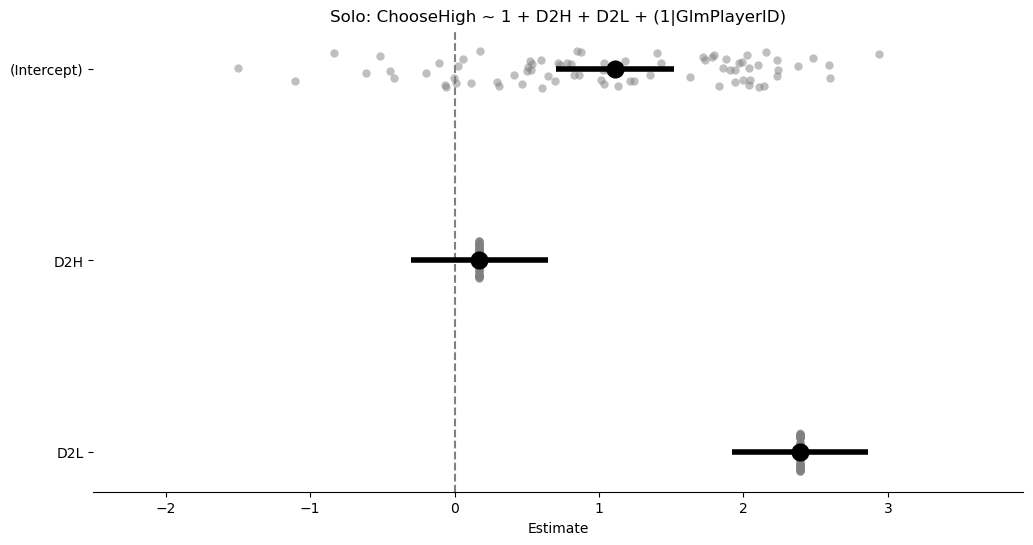

In [34]:
# define model formula
model_formula = 'ChooseHigh ~ 1 + D2H + D2L + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + FirstSeenWall + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + WallSep:FirstSeenWall + (1|GlmPlayerID)'
# model_formula = 'ChooseHigh ~ 1 + D2H + D2L + FirstSeenWall + WallSep + WallSep:FirstSeenWall + D2L:FirstSeenWall + D2H:FirstSeenWall + (1|GlmPlayerID)'


# fit the model
model = Lmer(model_formula, data=glm_df_solo, family='binomial')
results=model.fit(
    control="optimizer='bobyqa', optCtrl=list(maxfun=10000)"
)

# display model results
print(results)
ax = model.plot_summary()
ax.set_title("Solo: " + model_formula)

### run predictions of the model on all training data

In [35]:
glm_df_solo['FirstSeenWall'].unique()

['1.0', '2.0', '3.0', NaN]
Categories (3, object): ['1.0', '2.0', '3.0']

In [36]:
predictions = model.predict(glm_df_solo.dropna(subset='FirstSeenWall'), verify_predictions=False, skip_data_checks=True)
predictions = np.array(predictions)

In [37]:
filter_regressors = ['FirstSeenWall']
filter_regressor_values = [1]

In [38]:
regressor_names_list, regressor_values_list = [], []
bin_edges =  np.linspace(0,1,6) # 5 bins
min_count = 50
regressor_names_list = None
bin_var1 = 'D2H'

In [39]:
model.formula

'ChooseHigh~1+D2H+D2L+(1|GlmPlayerID)'

In [40]:
nan_containing_cols = list(glm_df_solo.isna().sum()[glm_df_solo.isna().sum() > 0].index)

# drop rows with nans in any columns that contain them (and are also in the model formula)
# 
df_copy = glm_df_solo.copy()
for column in nan_containing_cols:
    pattern = re.compile(column)
    match = re.search(pattern, model.formula)
    if match:
        print(f"Dropping {df_copy['FirstSeenWall'].isna().sum()} nans in column {column}")
        df_copy.dropna(subset=column, inplace=True)
    else:
        continue


In [41]:
glm_df_solo['FirstSeenWall'].unique()

['1.0', '2.0', '3.0', NaN]
Categories (3, object): ['1.0', '2.0', '3.0']

In [42]:
regressor_names_list = [['FirstSeenWall'],['FirstSeenWall']]
regressor_values_list = [[1],[2]]
for reg_names, reg_vals in zip(regressor_names_list, regressor_values_list):
    print(f"Regressor names: {reg_names}, regressor values: {reg_vals}")

Regressor names: ['FirstSeenWall'], regressor values: [1]
Regressor names: ['FirstSeenWall'], regressor values: [2]


In [43]:
help(compute_binned_heatmaps)

Help on function compute_binned_heatmaps in module __main__:

compute_binned_heatmaps(df, model, regressor_names_list, regressor_values_list, bin_var1, bin_var2, bin_edges, min_count=50)
    Compute bins for heatmaps, both mean predictions and mean ground truth. Do this for
    each subplot defined in regressor_names_list and regressor_values_list.
    NB: [1,4] is D2L 1, D2H 4, so the first index is the y axis (D2L) and the second is the x axis (D2H).

    Args:
    -----------
    df: full input data for the trained model.
    model: trained GLMM.
    regressor_names_list: list of lists of names of regressors used to filter each
    subplot (e.g. ['FirstSeenWall', 'WallSep']). If any nested list
    contains a single value None, no filter will be applied for this subplot.
    regressor_values_list: list of lists of regressor values to filter for in each subplot. These must
    agree with the regressor value types. Take care that FirstSeenWall is '1.0', '2.0', etc.
    (e.g. [[1, 2], 

In [44]:
# bin predictions based on groudtruth distances
# generate ground truth

def compute_binned_heatmaps(
    df, model, regressor_names_list, regressor_values_list, 
    bin_var1, bin_var2, bin_edges, min_count=50,
    ):
    """
    Compute bins for heatmaps, both mean predictions and mean ground truth. Do this for
    each subplot defined in regressor_names_list and regressor_values_list.
    NB: [1,4] is D2L 1, D2H 4, so the first index is the y axis (D2L) and the second is the x axis (D2H).
    
    Args:
    -----------
    df: full input data for the trained model.
    model: trained GLMM.
    regressor_names_list: list of lists of names of regressors used to filter each
    subplot (e.g. ['FirstSeenWall', 'WallSep']). If any nested list
    contains a single value None, no filter will be applied for this subplot.
    regressor_values_list: list of lists of regressor values to filter for in each subplot. These must
    agree with the regressor value types. Take care that FirstSeenWall is '1.0', '2.0', etc.
    (e.g. [[1, 2], [1, 2]]). To apply more than one value in the filter, use a list instead of a value 
    bin_var1, bin_var2: variables to bin (e.g. 'D2H', 'D2L').
    bin_edges: array-like, bin edges for both variables.
    min_count: minimum count per bin to include.
    Returns: lists of binned predictions and ground truth arrays for each subplot.
    """

    # list of 2D choice probability arrays for each subplot/data filter
    binned_predictions = []
    binned_groundtruth = []
    subplot = 0

    # loop through each subplot regressor filter, and each individual regressor within this
    # to create a mask for the data
    for reg_names, reg_vals in zip(regressor_names_list, regressor_values_list):
        subplot += 1
        print(f"Subplot {subplot} of {len(regressor_names_list)}")
        mask = np.ones(len(df), dtype=bool)
        for name, val in zip(reg_names, reg_vals):
            if name == None:
                print(f"No mask applied for subplot {subplot}")
                continue # no mask
            elif isinstance(val, (list, tuple, set, np.ndarray)):
                # if val is an interable of values, allow any of them in the mask
                mask &= (df[name].isin(val))
            else:
                # if a single value, only allow that value in the mask
                mask &= (df[name] == val)
        df_masked = df.copy()[mask] # apply the mask to the dataframe
        print(f"length of df_masked: {len(df_masked)}, length of df: {len(df)}")

        # drop rows with nans in any columns that contain them (and are also in the model formula)
        nan_containing_cols = list(glm_df_solo.isna().sum()[glm_df_solo.isna().sum() > 0].index)
        for column in nan_containing_cols:
            pattern = re.compile(column)
            match = re.search(pattern, model.formula)
            if match:
                print(f"Dropping {df_masked['FirstSeenWall'].isna().sum()} nans in column {column}")
                df_masked.dropna(subset=column, inplace=True)
            else:
                continue
        print(f"New length of df_masked: {len(df_masked)}")

        # return nans for prediction/ground truth if no data
        if df_masked.empty:
            binned_predictions.append(np.full((len(bin_edges) - 1, len(bin_edges) - 1), np.nan))
            binned_groundtruth.append(np.full((len(bin_edges) - 1, len(bin_edges) - 1), np.nan))
            continue

        print(f"length of df_masked: {len(df_masked)}, length of df: {len(df)}")
        
        # remove nan values from input data (cannot run predictions if there are any nans in the data)
        ### I should be careful about dropping nans, and when to do it. If I'm just looking at a model without
        # firstseenwall, it will have been trained on ALL rows. If the model includes firstseenwall, it will have been trained on a subset of the data.
        # df_masked = df_masked.dropna(subset='FirstSeenWall')
        predictions = np.array(model.predict(df_masked, verify_predictions=False, skip_data_checks=True))

        # bin ground truth distances 
        binned_D2H = np.digitize(df_masked[bin_var1], bin_edges) - 1
        binned_D2L = np.digitize(df_masked[bin_var2], bin_edges) - 1

        # create 2D np array of binned prediction + ground truth means
        arr_groundtruth = np.full((len(bin_edges) -1, len(bin_edges) - 1), np.nan)
        arr_predictions = np.full((len(bin_edges) -1, len(bin_edges) - 1), np.nan)
        
        # loop through bins and populate the 2D arrays
        for i in range(len(bin_edges) - 1):
            for j in range(len(bin_edges) - 1):
                # create mask for predictions
                mask = (binned_D2L == i) & (binned_D2H == j)
                print(f"n for bins ({i},{j}): {np.sum(mask)}")

                # calculate mean of predictions/gt for each bin
                mean_groundtruth = np.nanmean(df_masked['ChooseHigh'].values[mask])
                # print(f"type for mask is {type(mask)}")
                # print(f"mask is {mask}")
                # print(f"predictions is {predictions}")
                mean_prediction = np.nanmean(predictions[mask])

                # exclude bins with low counts
                if np.sum(mask) < min_count:
                    mean_prediction = np.nan
                    mean_groundtruth = np.nan

                # add to the 2D arrays
                arr_groundtruth[i,j] = mean_groundtruth
                arr_predictions[i,j] = mean_prediction
            
        # append subplot data to the list
        binned_predictions.append(arr_predictions)
        binned_groundtruth.append(arr_groundtruth)

    return binned_predictions, binned_groundtruth


In [45]:
glm_df_solo_dropna = glm_df_solo.dropna(subset='FirstSeenWall')
predictions = model.predict(glm_df_solo_dropna, verify_predictions=False, skip_data_checks=True)
predictions = np.array(predictions)

groundtruth_D2H = glm_df_solo_dropna['D2H'].values
groundtruth_D2L = glm_df_solo_dropna['D2L'].values
groundtruth_choice = glm_df_solo_dropna['ChooseHigh'].values

# generate bins
bin_counts = np.linspace(0, 1, 6) # 5 bins

# bin predictions
binned_D2H = np.digitize(groundtruth_D2H, bin_counts) - 1
binned_D2L = np.digitize(groundtruth_D2L, bin_counts) - 1

# create 2D np array of binned prediction + groundtruth means
binned_predictions = np.zeros((len(bin_counts) -1, len(bin_counts) - 1))
binned_groundtruth = np.zeros((len(bin_counts) -1, len(bin_counts) - 1))
for i in range(len(bin_counts) - 1):
    for j in range(len(bin_counts) - 1):

        # create mask for binned predictions
        mask = (binned_D2L == i) & (binned_D2H == j)
        print(f"n for bins ({i},{j}): {np.sum(mask)}")

        # calculate mean of predictions for each bin
        mean_prediction = np.nanmean(predictions[mask])

        # calculate mean of groundtruth for each bin
        mean_groundtruth = np.nanmean(groundtruth_choice[mask])

        # exclude bins with low counts
        if np.sum(mask) < 50:
            mean_prediction = np.nan
            mean_groundtruth = np.nan

        # add means to 2D arrays
        binned_predictions[i,j] = mean_prediction
        binned_groundtruth[i,j] = mean_groundtruth


n for bins (0,0): 15
n for bins (0,1): 73
n for bins (0,2): 69
n for bins (0,3): 47
n for bins (0,4): 71
n for bins (1,0): 78
n for bins (1,1): 289
n for bins (1,2): 442
n for bins (1,3): 258
n for bins (1,4): 85
n for bins (2,0): 55
n for bins (2,1): 445
n for bins (2,2): 1719
n for bins (2,3): 278
n for bins (2,4): 18
n for bins (3,0): 45
n for bins (3,1): 251
n for bins (3,2): 248
n for bins (3,3): 263
n for bins (3,4): 142
n for bins (4,0): 48
n for bins (4,1): 91
n for bins (4,2): 39
n for bins (4,3): 182
n for bins (4,4): 185


In [58]:
regressor_names_list, regressor_values_list = [['FirstSeenWall'], ['FirstSeenWall']], [['1.0'], ['2.0']]
bin_edges =  np.linspace(0,1,6) # 5 bins
min_count = 50

binned_predictions, binned_groundtruth = compute_binned_heatmaps(
    glm_df_solo, model, regressor_names_list, regressor_values_list, 
    'D2H', 'D2L', bin_edges, min_count)


Subplot 1 of 2
length of df_masked: 1962, length of df: 5544
New length of df_masked: 1962
length of df_masked: 1962, length of df: 5544
n for bins (0,0): 6
n for bins (0,1): 42
n for bins (0,2): 40
n for bins (0,3): 28
n for bins (0,4): 51
n for bins (1,0): 28
n for bins (1,1): 128
n for bins (1,2): 210
n for bins (1,3): 130
n for bins (1,4): 41
n for bins (2,0): 11
n for bins (2,1): 151
n for bins (2,2): 648
n for bins (2,3): 128
n for bins (2,4): 7
n for bins (3,0): 10
n for bins (3,1): 62
n for bins (3,2): 71
n for bins (3,3): 85
n for bins (3,4): 35
n for bins (4,0): 5
n for bins (4,1): 7
n for bins (4,2): 5
n for bins (4,3): 19
n for bins (4,4): 14
Subplot 2 of 2
length of df_masked: 1929, length of df: 5544
New length of df_masked: 1929
length of df_masked: 1929, length of df: 5544
n for bins (0,0): 9
n for bins (0,1): 18
n for bins (0,2): 16
n for bins (0,3): 8
n for bins (0,4): 12
n for bins (1,0): 35
n for bins (1,1): 105
n for bins (1,2): 157
n for bins (1,3): 74
n for bins 

/tmp/ipykernel_276997/1679741567.py:95: RuntimeWarning: Mean of empty slice
  mean_groundtruth = np.nanmean(df_masked['ChooseHigh'].values[mask])
/tmp/ipykernel_276997/1679741567.py:99: RuntimeWarning: Mean of empty slice
  mean_prediction = np.nanmean(predictions[mask])


In [59]:
glm_df_solo.value_counts('FirstSeenWall')

FirstSeenWall
1.0    1962
2.0    1929
3.0    1545
Name: count, dtype: int64

### Heatmap of P(ChooseHigh) as a function of D2H and D2L

In [60]:
def heatmap_subplots(binned_counts, layout, cmap='viridis', vmin=0, vmax=1, cbar=True, title=None):

    fig, axs = plt.subplots(layout[0], layout[1], figsize=(layout[1]*5, layout[0]*5), squeeze=False)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(layout[0]):
        for j in range(layout[1]):
            if i*layout[1] + j >= len(binned_counts):
                break
            ax = axs[i,j]
            # cbar = True if j == layout[1] - 1 else False
            ax = sns.heatmap(binned_counts[i*layout[1] + j], ax=ax, vmin=vmin,
                              vmax=vmax, annot=True, fmt='.2f', cmap=cmap, cbar=cbar)
            ax.set_xlabel('Distance to High')
            ax.set_ylabel('Distance to Low')
            # ax.set_title('Binned Ground Truth')
            ax.invert_yaxis()
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return fig, axs

In [61]:
test1 = 2
test2 = 3

for i in range(test1):
    for j in range(test2):
        if j == test2-1:
            print(f"i: {i}, j: {j}")

i: 0, j: 2
i: 1, j: 2


In [62]:
len(binned_groundtruth)

2

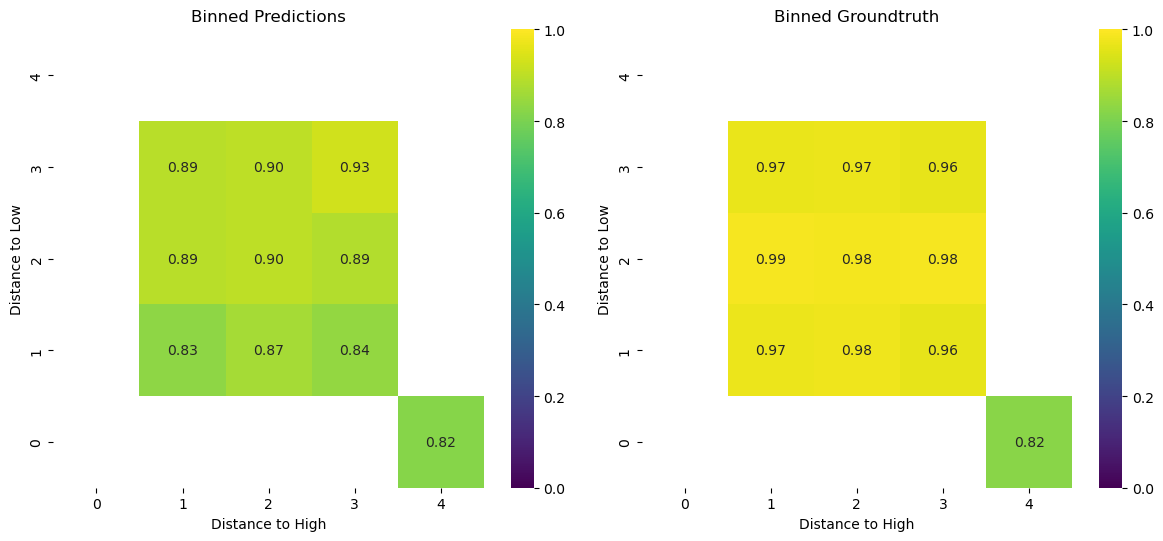

In [63]:
import seaborn as sns

figs, axs = plt.subplots(1,2, figsize=(12, 6))

# plot binned predictions and groundtruth
# tranpose arrays for plotting (distance to High on x-axis)
sns.heatmap(binned_predictions[0], vmin=0, vmax=1, annot=True, fmt=".2f", cmap='viridis', cbar=True, ax=axs[0])
axs[0].set_xlabel('Distance to High')
axs[0].set_ylabel('Distance to Low')
axs[0].set_title('Binned Predictions')
axs[0].invert_yaxis()

sns.heatmap(binned_groundtruth[0], vmin=0, vmax=1, annot=True, fmt=".2f", cmap='viridis', cbar=True, ax=axs[1])
axs[1].set_xlabel('Distance to High')
axs[1].set_ylabel('Distance to Low')
axs[1].set_title('Binned Groundtruth')
axs[1].invert_yaxis()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

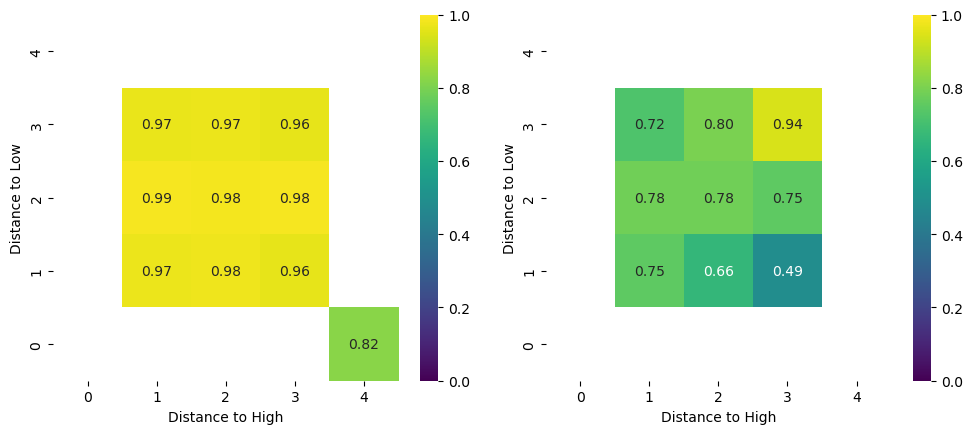

(<Figure size 1000x500 with 4 Axes>,
 array([[<Axes: xlabel='Distance to High', ylabel='Distance to Low'>,
         <Axes: xlabel='Distance to High', ylabel='Distance to Low'>]],
       dtype=object))

In [65]:
heatmap_subplots(binned_groundtruth, (1,2), cmap='viridis', cbar=True)

Subplot 1 of 6
length of df_masked: 771, length of df: 5544
New length of df_masked: 771
length of df_masked: 771, length of df: 5544
n for bins (0,0): 6
n for bins (0,1): 42
n for bins (0,2): 19
n for bins (0,3): 0
n for bins (0,4): 0
n for bins (1,0): 28
n for bins (1,1): 85
n for bins (1,2): 69
n for bins (1,3): 36
n for bins (1,4): 0
n for bins (2,0): 1
n for bins (2,1): 41
n for bins (2,2): 246
n for bins (2,3): 69
n for bins (2,4): 0
n for bins (3,0): 0
n for bins (3,1): 1
n for bins (3,2): 32
n for bins (3,3): 53
n for bins (3,4): 20
n for bins (4,0): 0
n for bins (4,1): 0
n for bins (4,2): 0
n for bins (4,3): 10
n for bins (4,4): 13
Subplot 2 of 6
length of df_masked: 575, length of df: 5544
New length of df_masked: 575
length of df_masked: 575, length of df: 5544
n for bins (0,0): 0
n for bins (0,1): 0
n for bins (0,2): 21
n for bins (0,3): 23
n for bins (0,4): 0
n for bins (1,0): 0
n for bins (1,1): 43
n for bins (1,2): 80
n for bins (1,3): 21
n for bins (1,4): 12
n for bins 

/tmp/ipykernel_276997/1679741567.py:95: RuntimeWarning: Mean of empty slice
  mean_groundtruth = np.nanmean(df_masked['ChooseHigh'].values[mask])
/tmp/ipykernel_276997/1679741567.py:99: RuntimeWarning: Mean of empty slice
  mean_prediction = np.nanmean(predictions[mask])


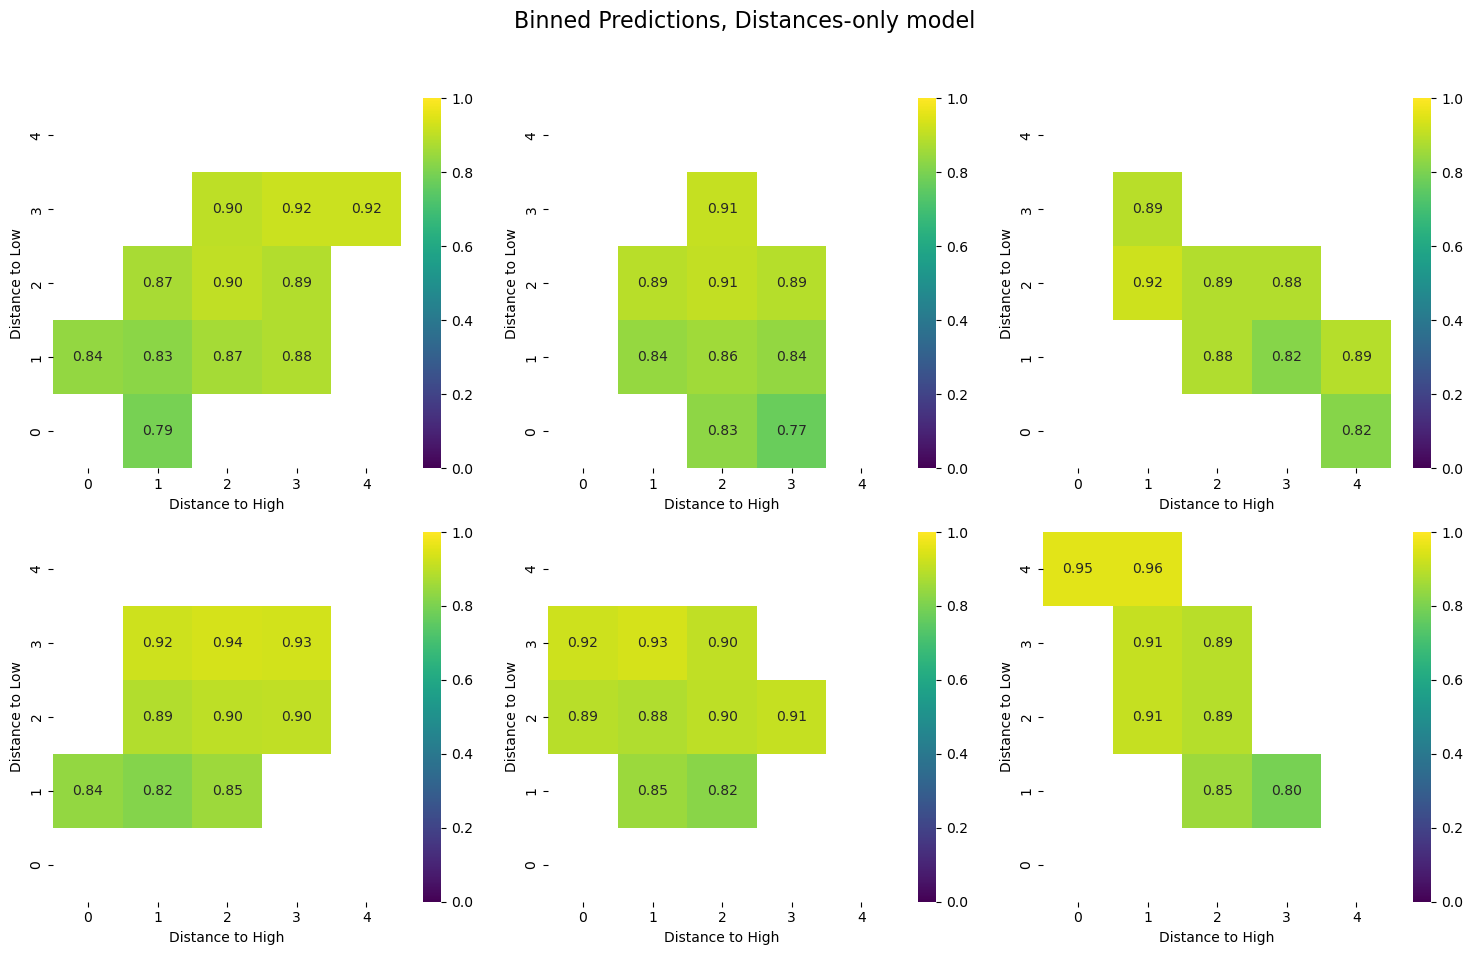

(<Figure size 1500x1000 with 12 Axes>,
 array([[<Axes: xlabel='Distance to High', ylabel='Distance to Low'>,
         <Axes: xlabel='Distance to High', ylabel='Distance to Low'>,
         <Axes: xlabel='Distance to High', ylabel='Distance to Low'>],
        [<Axes: xlabel='Distance to High', ylabel='Distance to Low'>,
         <Axes: xlabel='Distance to High', ylabel='Distance to Low'>,
         <Axes: xlabel='Distance to High', ylabel='Distance to Low'>]],
       dtype=object))

In [56]:
regressor_names_list, regressor_values_list = [['FirstSeenWall','WallSep']]*6, [['1.0',0.25], ['1.0',0.5], ['1.0',1],
                                                                                ['2.0',0.25], ['2.0',0.5], ['2.0',1]]
bin_edges =  np.linspace(0,1,6) # 5 bins
min_count = 20

binned_predictions, binned_groundtruth = compute_binned_heatmaps(
    glm_df_solo, model, regressor_names_list, regressor_values_list, 
    'D2H', 'D2L', bin_edges, min_count)

heatmap_subplots(binned_predictions, (2,3), cmap='viridis', cbar=True, title='Binned Predictions, Distances-only model')